#### Set up the environment - import packages

In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import pathlib
import shutil
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image as pillow

#### Data check
Initial dataset contains 3,000 training images

In [2]:
for dirname, _, _ in os.walk('Brain_Tumor_Detection'):
        print(dirname)

Brain_Tumor_Detection
Brain_Tumor_Detection/no
Brain_Tumor_Detection/yes


In [3]:
import pathlib
directory = "Brain_Tumor_Detection/"
data_dir = pathlib.Path(directory)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3000


In [4]:
pixel = []
target = []

for dataclass in glob(directory+'/*'):
    for file in glob(dataclass+'/*'):
        pixels = mpl.image.imread(file)
        pixel.append(pixels) 
        target.append(dataclass.split("/")[-1])

In [5]:
df = pd.DataFrame({'image': pixel,'target': target})
df["target"] = df.target.str.replace("pred","test_set")

Initial training dataset is split evenly between positive (has tumor) and negative (no tumor) class

([<matplotlib.patches.Wedge at 0x7f930d596400>,
 [Text(6.735557395310444e-17, 1.1, 'yes'),
  Text(-2.0206672185931328e-16, -1.1, 'no')],
 [Text(3.6739403974420595e-17, 0.6, '50%'),
  Text(-1.1021821192326178e-16, -0.6, '50%')])

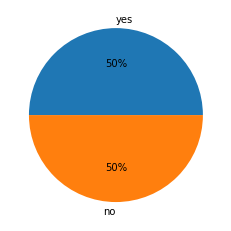

In [6]:
plt.pie(df[df.target!="test_set"].target.value_counts(), labels=['yes','no'], autopct='%0.0f%%')

Visual inspection of the data in training datasets below

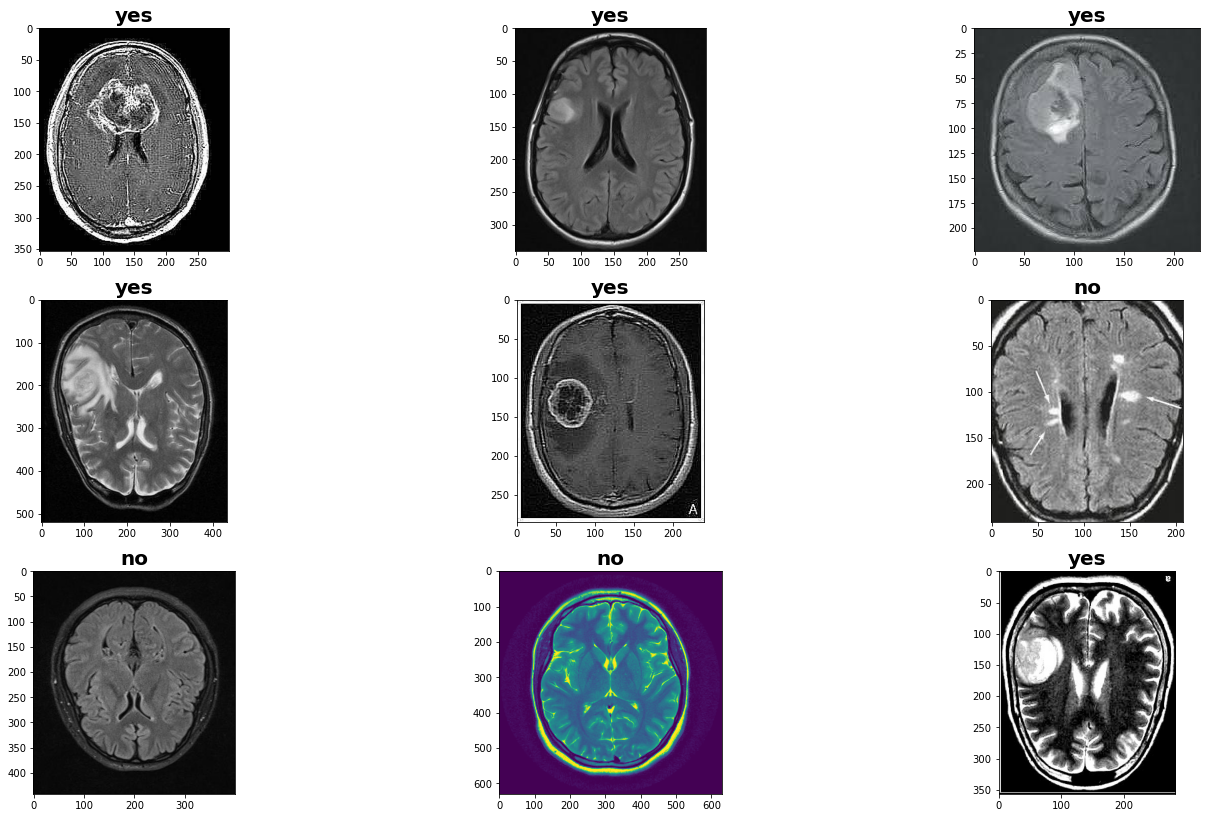

In [10]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(3000)
    plt.title('{0}'.format(df.target[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(df.image[index])
    plt.tight_layout()

#### Baseline model to benchmark against CNNs
Logistic regression with 2 PCA vectors

In [18]:
from pathlib import Path
import os
import cv2
from sklearn.decomposition import PCA

trainpath = Path('/Users/nk/Documents/Metis/06 Deep Learning/Project/brain_tumor 2/training')
testpath = Path('/Users/nk/Documents/Metis/06 Deep Learning/Project/brain_tumor 2/test')

tr_labels = []
tr_pixels = []

for file in trainpath.glob('*/*.jpg'):
    tr_labels.append(os.path.dirname(file).split("/")[-1])
    images = cv2.imread(os.path.relpath(file))
    resized = cv2.resize(images, (250,250), interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    tr_pixels.append(gray.ravel())

te_labels = []
te_pixels = []

for file in testpath.glob('*/*.jpg'):
    te_labels.append(os.path.dirname(file).split("/")[-1])
    images = cv2.imread(os.path.relpath(file))
    resized = cv2.resize(images, (250,250), interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    te_pixels.append(gray.ravel())

In [19]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_train = scaler.fit_transform(tr_pixels)
X_test = scaler.transform(te_pixels)

pca = PCA(n_components=2)

X_train_2PC = pca.fit_transform(X_train)
X_test_2PC = pca.transform(X_test)

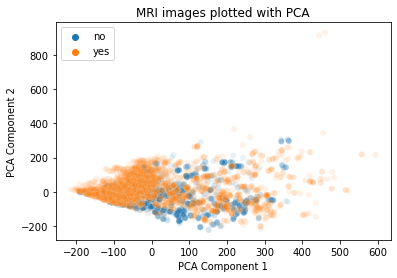

In [20]:
sns.scatterplot(x=X_train_2PC[:, 0], y=X_train_2PC[:, 1],hue=tr_labels, alpha=.1)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("MRI images plotted with PCA")
plt.legend(loc=2);

In [21]:
from sklearn.linear_model import LogisticRegression

In [23]:
pca = PCA(n_components=0.8)

lr = LogisticRegression()
lr.fit(X_train_2PC, tr_labels)
lr.score(X_test_2PC, te_labels)

0.7346128391793514

Baseline classification accuracy is 73% with logistic regression - lets see if Neural Network models can outperform this benchmark

#### Environment set up for CNN

In [44]:
data_dir = pathlib.Path("Brain_Tumor_Detection/")
test_dir = pathlib.Path("Brain_Tumor_Detection_pred")

In [45]:
batch = 32
img_height = 250
img_width = 250
img_size = (img_height, img_width)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size=batch,
    labels='inferred',
    image_size=img_size,
    validation_split=0.25,
    subset='training',
    seed=2018,
    color_mode='grayscale'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size=batch,
    labels='inferred',
    image_size=img_size,
    validation_split=0.25,
    subset='validation',
    seed=2018,
    color_mode='grayscale'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    color_mode='grayscale'
)

Found 3000 files belonging to 2 classes.
Using 2250 files for training.
Found 3000 files belonging to 2 classes.
Using 750 files for validation.
Found 60 files belonging to 1 classes.


#### Training baseline CNN

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [46]:
baseline = Sequential()

baseline.add(InputLayer(input_shape=(250,250,1)))

baseline.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
baseline.add(MaxPooling2D((2,2)))
baseline.add(Flatten())
baseline.add(Dense(1, activation='sigmoid'))

baseline.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [47]:
baseline.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 250, 250, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 500000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 500001    
Total params: 500,321
Trainable params: 500,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
baseline_cnn_result = baseline.fit(train_dataset, validation_data = test_dataset, epochs=20, callbacks=[EarlyStopping(patience=5, verbose=1)])

Epoch 1/20
71/71 [==============================] - 21s 298ms/step - loss: 109.2501 - accuracy: 0.7533 - val_loss: 7.1941 - val_accuracy: 0.8500
Epoch 2/20
71/71 [==============================] - 21s 297ms/step - loss: 4.9893 - accuracy: 0.9004 - val_loss: 13.9014 - val_accuracy: 0.6833
Epoch 3/20
71/71 [==============================] - 21s 297ms/step - loss: 1.1602 - accuracy: 0.9587 - val_loss: 17.5110 - val_accuracy: 0.6500
Epoch 4/20
71/71 [==============================] - 21s 298ms/step - loss: 0.6390 - accuracy: 0.9702 - val_loss: 15.5476 - val_accuracy: 0.6833
Epoch 5/20
71/71 [==============================] - 21s 295ms/step - loss: 0.1441 - accuracy: 0.9889 - val_loss: 16.0430 - val_accuracy: 0.6333
Epoch 6/20
71/71 [==============================] - 21s 296ms/step - loss: 0.0628 - accuracy: 0.9951 - val_loss: 15.9871 - val_accuracy: 0.6500
Epoch 00006: early stopping


In [53]:
predictions_b = baseline.predict(test_dataset, verbose=1)

2/2 [==============================] - 0s 88ms/step


In [54]:
baseline.save('baseline_cnn.h5')

#### Training custom CNN with multiple Conv2D layers

In [55]:
custom = Sequential()

custom.add(InputLayer(input_shape=(250,250,1)))

custom.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
custom.add(MaxPooling2D())

custom.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))

custom.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))

custom.add(Conv2D(filters=64, kernel_size=5, activation='relu', padding='same'))
custom.add(MaxPooling2D())

custom.add(Conv2D(filters=10, kernel_size=7, activation='relu', padding='same'))
custom.add(Flatten())
custom.add(Dense(1, activation='sigmoid'))
custom
custom.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [56]:
custom.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 250, 250, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 64)      102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 10)       

In [58]:
custom_cnn_result = custom.fit(train_dataset, validation_data = test_dataset, epochs=20, callbacks=[EarlyStopping(patience=5, verbose=1)])

Epoch 1/20
71/71 [==============================] - 384s 5s/step - loss: 1.0494 - accuracy: 0.6649 - val_loss: 0.7180 - val_accuracy: 0.4667
Epoch 2/20
71/71 [==============================] - 382s 5s/step - loss: 0.5032 - accuracy: 0.7796 - val_loss: 0.8767 - val_accuracy: 0.5000
Epoch 3/20
71/71 [==============================] - 385s 5s/step - loss: 0.4124 - accuracy: 0.8151 - val_loss: 1.0935 - val_accuracy: 0.6167
Epoch 4/20
71/71 [==============================] - 389s 5s/step - loss: 0.3444 - accuracy: 0.8542 - val_loss: 1.3979 - val_accuracy: 0.5667
Epoch 5/20
71/71 [==============================] - 388s 5s/step - loss: 0.2788 - accuracy: 0.8898 - val_loss: 1.5999 - val_accuracy: 0.6333
Epoch 6/20
71/71 [==============================] - 389s 5s/step - loss: 0.2318 - accuracy: 0.9071 - val_loss: 1.7956 - val_accuracy: 0.6333
Epoch 00006: early stopping


In [59]:
custom_cnn_result = custom.fit(train_dataset, validation_data = test_dataset, epochs=20, callbacks=[EarlyStopping(patience=10, verbose=1)])

Epoch 1/20
71/71 [==============================] - 410s 6s/step - loss: 0.1480 - accuracy: 0.9476 - val_loss: 2.0513 - val_accuracy: 0.6000
Epoch 2/20
71/71 [==============================] - 391s 6s/step - loss: 0.1102 - accuracy: 0.9631 - val_loss: 2.0744 - val_accuracy: 0.6333
Epoch 3/20
71/71 [==============================] - 391s 5s/step - loss: 0.0624 - accuracy: 0.9822 - val_loss: 2.8650 - val_accuracy: 0.6000
Epoch 4/20
71/71 [==============================] - 398s 6s/step - loss: 0.0416 - accuracy: 0.9831 - val_loss: 2.8132 - val_accuracy: 0.5667
Epoch 5/20
71/71 [==============================] - 408s 6s/step - loss: 0.0620 - accuracy: 0.9782 - val_loss: 2.8412 - val_accuracy: 0.5667
Epoch 6/20
71/71 [==============================] - 408s 6s/step - loss: 0.1307 - accuracy: 0.9591 - val_loss: 2.3477 - val_accuracy: 0.5500
Epoch 7/20
71/71 [==============================] - 408s 6s/step - loss: 0.0426 - accuracy: 0.9884 - val_loss: 4.2165 - val_accuracy: 0.5000
Epoch 8/20
71

In [60]:
custom.save('custom_cnn.h5')

In [63]:
predictions_c = custom.predict(test_dataset, verbose=1)

2/2 [==============================] - 4s 2s/step


First CNN model with one Conv2D layer was able to reach almost 100% accuracy. This doesn't change much with the CNN model with multiple Conv2D layer. Considering the speed, the simpler CNN model would be an obvious preference but I want to check for each model's ability to generalize to test dataset.